# Example for calculating density from the equation of state

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, glob, os 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from netCDF4 import Dataset   
import pyicon as pyic
import cartopy.crs as ccrs 

## Load data

Load dataset:

In [3]:
run       = 'slo1284'
gname_atm = 'r2b4a'
lev_atm   = 'L84'
rgrid_name = 'global_0.3'
t1 = np.datetime64('1630-02-01')
t2 = np.datetime64('1640-01-01')
                 
path_data     = '/work/mh0469/m211032/Icon/Git_Icon/icon.oes.20200506/experiments/'+run+'/'
path_grid_atm = '/mnt/lustre01/work/mh0033/m300602/icon/grids/'+gname_atm+'/'         
                
tstep     = '????????????????'

In [4]:
fname = '%s_atm_3d_ml_%s.nc' % (run, tstep)                                           
print('Dataset %s' % (fname))
IcD_atm3d = pyic.IconData(                                                            
               fname        = fname,                                                  
               path_data    = path_data,
               path_grid    = path_grid_atm,                                          
               gname        = gname_atm,
               lev          = lev_atm,                                                
               rgrid_name   = rgrid_name,                                             
               do_triangulation = True,                                               
               omit_last_file = False,                                                
               load_vertical_grid = False,  
               calc_coeff   = False,
               time_mode = 'float2date',                                              
              )                                                                       
fpath_ckdtree_atm = IcD_atm3d.rgrid_fpath_dict[rgrid_name]

Dataset slo1284_atm_3d_ml_????????????????.nc
::: Warning: Could not find any section-npz-file in /mnt/lustre01/work/mh0033/m300602/icon/grids/r2b4a/ckdtree/sections/. :::
::: Warning: no section found.:::


Load pressure, density and vert. vel. [Pa/s]:

In [5]:
IcD.path_data

NameError: name 'IcD' is not defined

In [7]:
pfull, it_ave   = pyic.time_average(IcD_atm3d, 'pfull', t1=t1, t2=t2, iz='all') 
rho, it_ave = pyic.time_average(IcD_atm3d, 'rho', t1=t1, t2=t2, iz='all')
ta, it_ave = pyic.time_average(IcD_atm3d, 'ta', t1=t1, t2=t2, iz='all')
hus, it_ave = pyic.time_average(IcD_atm3d, 'hus', t1=t1, t2=t2, iz='all')

pyicon.time_average: var=pfull: it_ave=[ 960  961  962  963  964  965  966  967  968  969  970  971  972  973
  974  975  976  977  978  979  980  981  982  983  984  985  986  987
  988  989  990  991  992  993  994  995  996  997  998  999 1000 1001
 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015
 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029
 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043
 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057
 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071
 1072 1073 1074 1075 1076 1077 1078 1079]
pyicon.time_average: var=rho: it_ave=[ 960  961  962  963  964  965  966  967  968  969  970  971  972  973
  974  975  976  977  978  979  980  981  982  983  984  985  986  987
  988  989  990  991  992  993  994  995  996  997  998  999 1000 1001
 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015
 1016 1017 1018 1019 1020 1021

In [9]:
rgas = 287.07
tv = ta * (1+0.608*hus)

In [17]:
rho_self = pfull/(rgas*tv)

Interoplate to regular grid.

In [18]:
lon, lat, rhoi = pyic.interp_to_rectgrid(rho, fpath_ckdtree_atm, coordinates='clat clon')
lon, lat, rho_selfi = pyic.interp_to_rectgrid(rho_self, fpath_ckdtree_atm, coordinates='clat clon')

Plot the data at model level:

Text(0.5, 1.0, 'rho-rho_self at level 41')

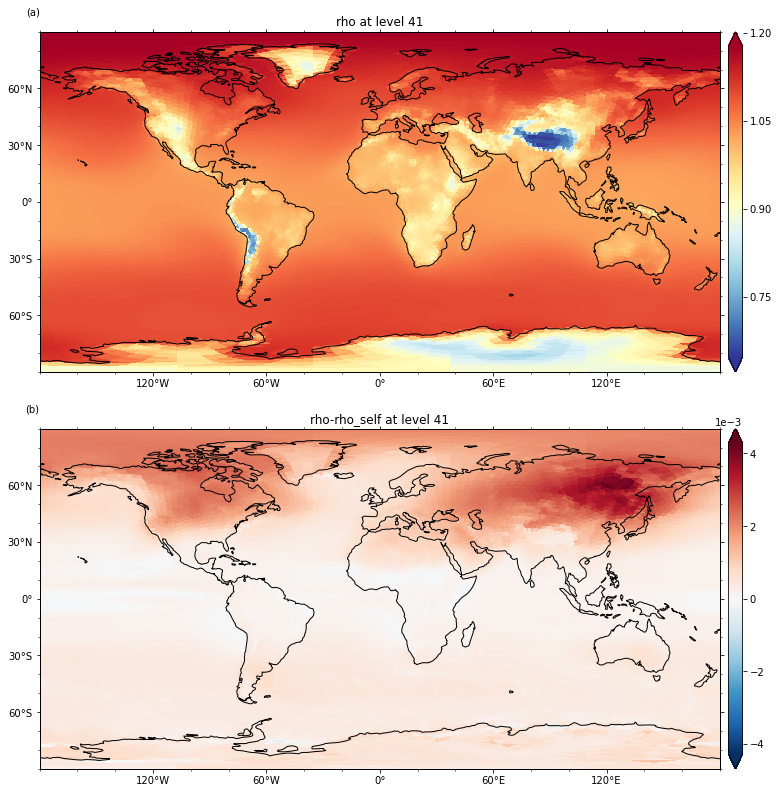

In [22]:
iz = 40
ccrs_proj = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(1,2, asp=0.5, projection=ccrs_proj, fig_size_fac=3, sharex=False)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, rhoi[iz,:], ax=ax, cax=cax, clim='auto', contfs=None, projection=ccrs.PlateCarree())
pyic.plot_settings(ax, template='global', land_facecolor='none')
ax.set_title('rho at level %d'%(iz+1))

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, rhoi[iz,:]-rho_selfi[iz,:], ax=ax, cax=cax, clim='sym', contfs=None, projection=ccrs.PlateCarree())
pyic.plot_settings(ax, template='global', land_facecolor='none')
ax.set_title('rho-rho_self at level %d'%(iz+1))

## Zonal averages

In [23]:
IcD_atm3d.plevc = np.array([100000,92500,85000,77500,70000,60000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,1000])
icall, ind_lev, fac = pyic.calc_vertical_interp_weights(pfull, IcD_atm3d.plevc)

In [24]:
lat_sec, rho_zave = pyic.zonal_average_atmosphere(rho, ind_lev, fac, fpath_ckdtree_atm)
lat_sec, rho_self_zave = pyic.zonal_average_atmosphere(rho_self, ind_lev, fac, fpath_ckdtree_atm)

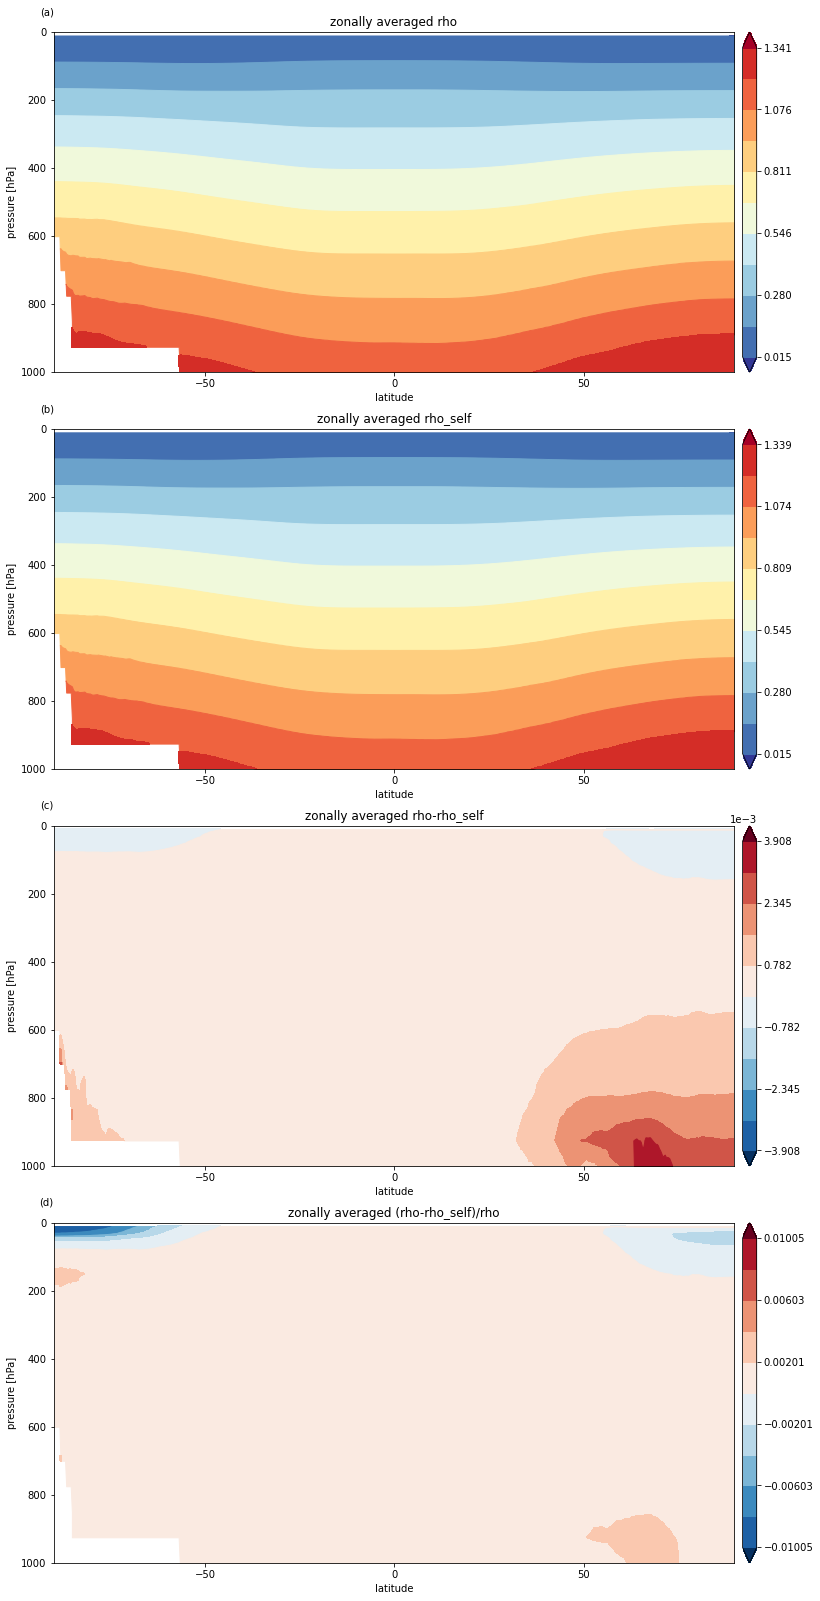

In [27]:
hca, hcb = pyic.arrange_axes(1,4, asp=0.5, fig_size_fac=3, sharex=False)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lat_sec, IcD_atm3d.plevc/100, rho_zave, ax=ax, cax=cax, clim='auto', contfs='auto')
ax.set_title('zonally averaged rho')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lat_sec, IcD_atm3d.plevc/100, rho_self_zave, ax=ax, cax=cax, clim='auto', contfs='auto')
ax.set_title('zonally averaged rho_self')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lat_sec, IcD_atm3d.plevc/100, rho_zave-rho_self_zave, ax=ax, cax=cax, clim='sym', contfs='auto')
ax.set_title('zonally averaged rho-rho_self')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lat_sec, IcD_atm3d.plevc/100, (rho_zave-rho_self_zave)/rho_zave, ax=ax, cax=cax, clim='sym', contfs='auto')
ax.set_title('zonally averaged (rho-rho_self)/rho')

for ax in hca:
    ax.set_ylim(1000,0)
    ax.set_xlabel('latitude')
    ax.set_ylabel('pressure [hPa]')